In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.datasets import load_svmlight_file
from math import sqrt

In [4]:
from forecaster import *
from environment import *
#from pnk import PROSNKONS

In [5]:
def dataset_to_stream(X, y):
    for t in np.random.permutation(range(X.shape[0])):
        yield np.squeeze(np.asarray(X[t,:])), y[t]
        
def scale_pos(X):
    X -= X.min(axis=0)
    return np.nan_to_num(X/X.max(axis=0))

In [6]:
dataset_name = "casp"
dataset_to_file = {}
dataset_to_file["casp"] = "CASP.csv"
dataset_to_file["ijcnn1"] = "ijcnn1"
dataset_to_file["cod-rna"] = "cod-rna.t"
dataset_to_file["susy"] = "SUSY.csv"

if dataset_name in ["cpusmall", "cadata", "year","ijcnn1", "cod-rna"]:
    X, y = load_svmlight_file("datasets/"+dataset_to_file[dataset_name])
    X = X.todense()
else:
    df = pd.read_csv("datasets/"+dataset_to_file[dataset_name], nrows=1000000)
    X = np.nan_to_num(df.values[:,1:])
    y = 2*df.values[:,0] - 1 
stream = list(dataset_to_stream(scale_pos(np.array(X)), y/y.max()))
d = X.shape[1]

In [7]:
if dataset_name == "susy":
    sig = 4
else:
    sig = 1
rbf_kernel = lambda x0,x1: np.exp(-np.linalg.norm(x0-x1)**2/(2*sig**2))
square_loss = lambda p,y: (p-y)**2
def loss_01(pred, y):
    if np.sign(pred) == 0:
        return np.random.randint(2)
    else:
        return (np.sign(pred) != np.sign(y))
timeout = 60*10
if dataset_name == "casp":
    test_loss = square_loss
else:
    test_loss = loss_01

In [8]:
FODG_L = run_on_stream(stream, test_loss, Fourier_online_GD_reg(d, 1000, sig, 1./sqrt(len(stream))), timeout=timeout)

In [9]:
pros_n_kons_L = run_on_stream(stream, test_loss, Pros_n_kons(d, 1., rbf_kernel, alpha=1e0, beta=1.), timeout=timeout)

In [10]:
r = 2
taylor2_ridge_L = run_on_stream(stream, test_loss, Ridge_reg(len(compute_taylor_features([0]*d,r,sig)), phi=lambda x:compute_taylor_features(x,r,sig)), timeout=timeout)

In [15]:
r = 3
taylor3_ridge_L = run_on_stream(stream, test_loss, Ridge_reg(len(compute_taylor_features([0]*d,r,sig)), phi=lambda x:compute_taylor_features(x,r,sig)), timeout=timeout)

In [12]:
nystrom_ridge_L = run_on_stream(stream, test_loss, Nystrom_chol_kernel_ridge_reg(d, rbf_kernel, lbd=1., beta=1.), timeout=timeout)

In [13]:
ridge_L = run_on_stream(stream, test_loss, Kernel_ridge_reg(d, rbf_kernel, lbd=1.), timeout=timeout)

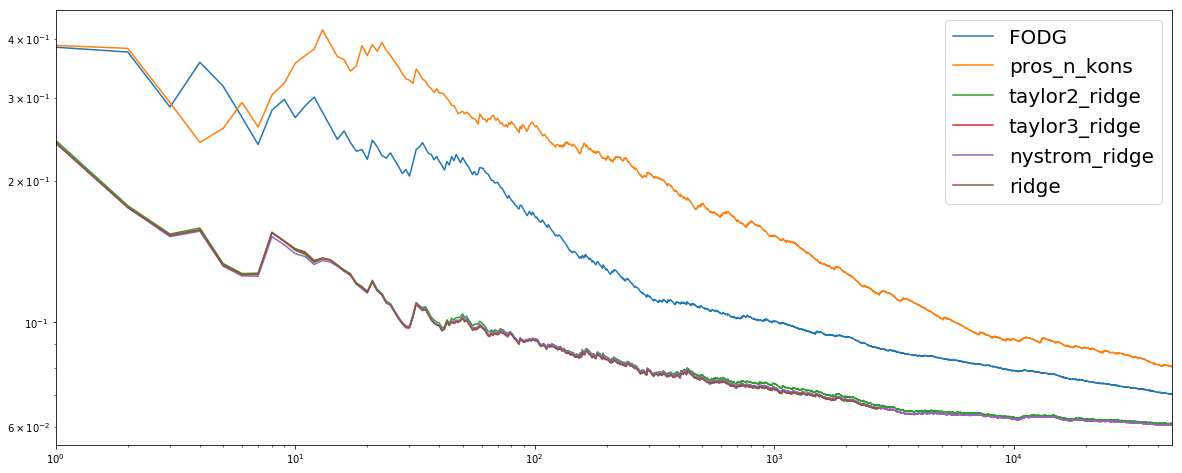

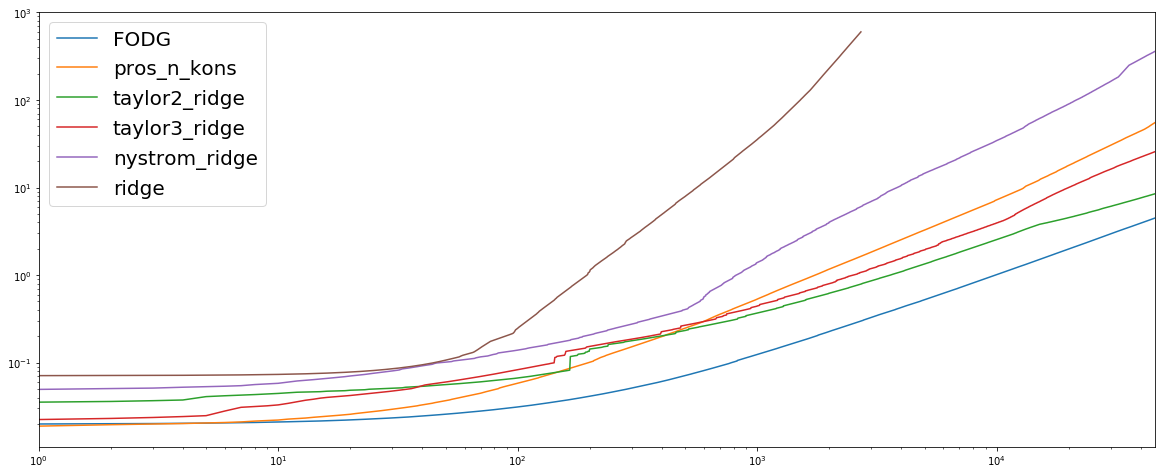

In [16]:
for opt in [0,1]:
    range_t = np.array(range(len(stream)))
    df = pd.DataFrame(index=range_t)
    df['FODG'] = FODG_L[opt]
    df['pros_n_kons'] = pros_n_kons_L[opt]
    #df['pnk'] = pnk_L[opt]
    df['taylor2_ridge'] = taylor2_ridge_L[opt]
    df['taylor3_ridge'] = taylor3_ridge_L[opt]
    df['nystrom_ridge'] = nystrom_ridge_L[opt]
    df['ridge'] = ridge_L[opt]
    if opt == 0:
        df /= np.concatenate([np.array(range(1,df.shape[0]+1))[:,None]]*df.shape[1], axis=1)
    df.plot(figsize=(20,8), logx=True, logy=True)#, xlim=[0,4000], ylim=[0,20])
    plt.legend(prop={'size': 20})
    plt.show()
    df.to_csv("results/"+dataset_name+"_"+("loss" if opt == 0 else "time"))